In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [2]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [4]:
files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_01.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_02.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_03.vhdr"
]

raw_list = [mne.io.read_raw_brainvision(f, preload=True) for f in files]

raw = mne.concatenate_raws(raw_list)
raw.set_channel_types({
    'C3-Cz':'eeg',
    'Oz-Cz':'eeg',
    'EOG1-EOG2':'eog',
    'EMG1-EMG2':'emg'
})
scores_files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_01_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_02_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_03_hypnogram.npy"
]
score_list = [np.load(f) for f in scores_files]
hypno = np.concatenate(score_list)
hypno = hypno.astype(int)
eeg_duration = raw.n_times / raw.info['sfreq']
n_epochs = int(eeg_duration // (30))  # assuming 30s epochs
hypno = hypno[:n_epochs]            # crop to EEG length if needed
stage_mapping = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
description = [stage_mapping[s] for s in hypno]
onset = np.arange(len(hypno)) * 30  # 30s per epoch
duration = np.repeat(30, len(hypno))
#
annotations = mne.Annotations(onset, duration, description)
raw.set_annotations(annotations)

Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_01.vhdr...
Setting channel info structure...
Reading 0 ... 3596783  =      0.000 ... 14387.132 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_02.vhdr...
Setting channel info structure...
Reading 0 ... 3599951  =      0.000 ... 14399.804 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_03.vhdr...
Setting channel info structure...
Reading 0 ... 3599871  =      0.000 ... 14399.484 secs...


<RawBrainVision | 2_night1_01.dat, 4 x 10796608 (43186.4 s), ~329.5 MiB, data loaded>

In [5]:
files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_01.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_02.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_03.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_04.vhdr"
]

raw_list = [mne.io.read_raw_brainvision(f, preload=True) for f in files]

raw_test = mne.concatenate_raws(raw_list)
raw_test.set_channel_types({
    'C3-Cz':'eeg',
    'Oz-Cz':'eeg',
    'EOG1-EOG2':'eog',
    'EMG1-EMG2':'emg'
})

scores_files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night2_01_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night2_02_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night2_03_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night2_04_hypnogram.npy"
]
score_list = [np.load(f) for f in scores_files]
hypno = np.concatenate(score_list)
hypno = hypno.astype(int)
eeg_duration = raw_test.n_times / raw_test.info['sfreq']
n_epochs = int(eeg_duration // (30))  # assuming 30s epochs
hypno = hypno[:n_epochs]            # crop to EEG length if needed
stage_mapping = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
description = [stage_mapping[s] for s in hypno]
onset = np.arange(len(hypno)) * 30  # 30s per epoch
duration = np.repeat(30, len(hypno))
#
annotations = mne.Annotations(onset, duration, description)
raw_test.set_annotations(annotations)

Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_01.vhdr...
Setting channel info structure...
Reading 0 ... 2950863  =      0.000 ... 11803.452 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_02.vhdr...
Setting channel info structure...
Reading 0 ... 3599983  =      0.000 ... 14399.932 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_03.vhdr...
Setting channel info structure...
Reading 0 ... 3600015  =      0.000 ... 14400.060 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night2_04.vhdr...
Setting channel info structure...
Reading 0 ... 1058335  =      0.000 ...  4233.340 secs...


<RawBrainVision | 2_night2_01.dat, 4 x 11209200 (44836.8 s), ~342.1 MiB, data loaded>

<RawBrainVision | 2_night1_01.dat, 4 x 10796608 (43186.4 s), ~329.5 MiB, data loaded>

In [6]:
events, event_id = mne.events_from_annotations(raw)
events_test, event_id_test = mne.events_from_annotations(raw_test)
print("Event dict:", event_id)
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # one 30s epoch
epochs = mne.Epochs(
    raw=raw,
    events=events,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    detrend=1,
    preload=True,
)
tmax = 30.0 - 1.0 / raw_test.info["sfreq"]  # 30s epochs
epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id_test,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    preload=True
)

Used Annotations descriptions: [np.str_('N1'), np.str_('N2'), np.str_('N3'), np.str_('REM'), np.str_('Wake')]
Used Annotations descriptions: [np.str_('N1'), np.str_('N2'), np.str_('N3'), np.str_('REM'), np.str_('Wake')]
Event dict: {np.str_('N1'): 10001, np.str_('N2'): 10002, np.str_('N3'): 10003, np.str_('REM'): 10004, np.str_('Wake'): 10005}
Not setting metadata
1439 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1439 events and 7500 original time points ...
0 bad epochs dropped
Not setting metadata
1494 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1494 events and 7500 original time points ...
0 bad epochs dropped


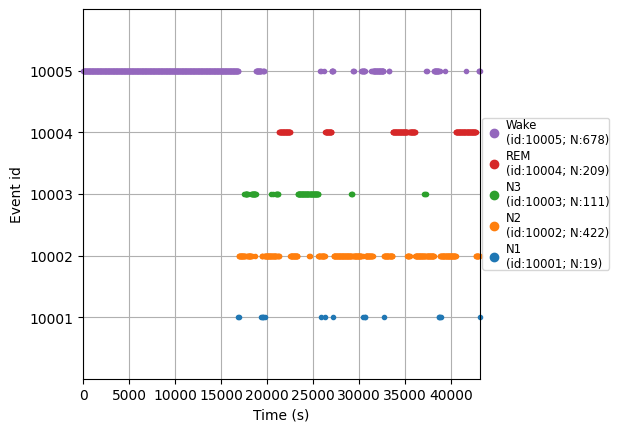

In [12]:
fig = mne.viz.plot_events(
    events,
    sfreq=raw.info["sfreq"],
    first_samp=raw.first_samp,
    event_id=event_id,   # 👈 ensures y-axis has stage labels
)

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


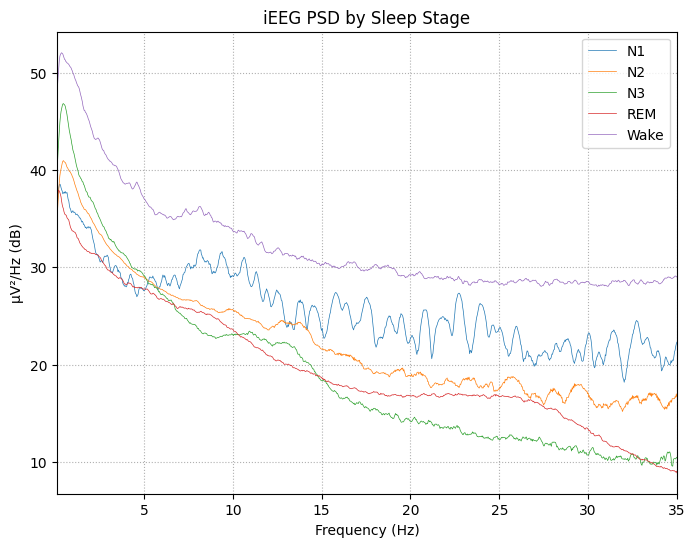

In [14]:
stages = sorted(event_id.keys())
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(8, 6))

for stage, color in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=35.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax,
        show=False,
        average=True,
        amplitude=False,
        spatial_colors=False,
        picks="data",   # or "seeg" since this is intracranial
        exclude="bads",
    )

ax.set(
    title="iEEG PSD by Sleep Stage",
    xlabel="Frequency (Hz)",
    ylabel="µV²/Hz (dB)",
)
ax.legend(ax.lines[2::3], stages)

plt.show()

In [7]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs.events[:, 2]
pipe.fit(epochs, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.8942436412315931


In [8]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

[[  0   0   0   1  13]
 [  0 435  17  14  23]
 [  0   8  66   0   1]
 [  0  36   0 180  24]
 [  0  13   0   8 655]]
              precision    recall  f1-score   support

          N1       0.00      0.00      0.00        14
          N2       0.88      0.89      0.89       489
          N3       0.80      0.88      0.84        75
         REM       0.89      0.75      0.81       240
        Wake       0.91      0.97      0.94       676

    accuracy                           0.89      1494
   macro avg       0.70      0.70      0.70      1494
weighted avg       0.89      0.89      0.89      1494



C:\Users\timmi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\timmi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\timmi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


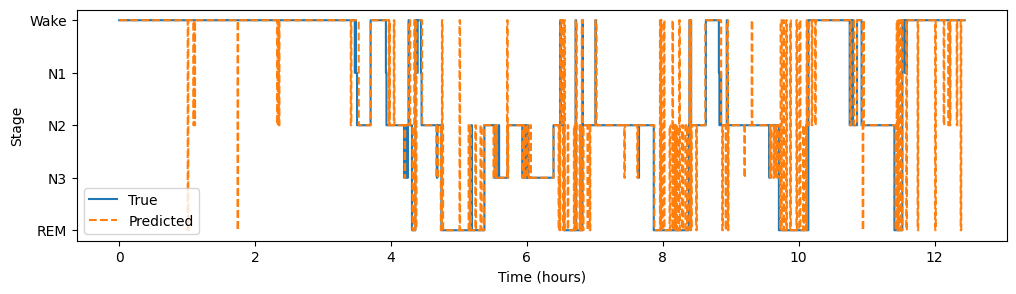

In [13]:
id_to_stage = {v: k for k, v in event_id.items()}
y_test_labels = [id_to_stage[y] for y in y_test]
y_pred_labels = [id_to_stage[y] for y in y_pred]

plt.figure(figsize=(12, 3))
plt.step(np.arange(len(y_test)) * 30 / 3600, y_test_labels, where='post', label='True')
plt.step(np.arange(len(y_pred)) * 30 / 3600, y_pred_labels, where='post', label='Predicted', linestyle='--')

plt.xlabel("Time (hours)")
plt.ylabel("Stage")
plt.legend()

plt.gca().invert_yaxis()
plt.savefig("predicted_vs_true.svg", format='svg')
plt.show()